In [1]:
#dl.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#24 January 2018

In [2]:
#import matplotlib pandas etc
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from matplotlib import rcParams
sns.set(font_scale=1.5, font='DejaVu Sans')
pd.set_option('display.max_columns', None)
pd.set_option('display.height', None)
pd.set_option('display.width', None)
import time
time_start = time.time()

height has been deprecated.



In [3]:
#read 'chunks' dataframe; each record contains a random 100-word-long chunk of text from one of 89
#books from the gutenberg project
import pickle
with open('chunks.pkl', 'rb') as fp:
    chunks = pickle.load(fp)
print 'number of records = ', len(chunks)
print 'number of books = ', len(chunks['input_file'].unique())
chunks.head()

number of records =  125271
number of books =  88


,author,author_id,title,input_file,text_chunk
117538,Jules Verne,48,The Mysterious Island,iso/etext98/milnd11.txt,it was fed from some hidden source. The differ...
83826,Bram Stoker,9,Dracula,iso/etext95/dracu12.txt,that in saying this I am doing what my dear on...
82201,Laura S. Haviland,51,A Woman'S Life-Work,iso/etext05/wlwrk10.txt,in great excitement and asked her if she wante...
99610,William Makepeace Thackeray,86,Vanity Fair,iso/etext96/vfair12.txt,little heart beating with joy? Her letters hom...
2696,Dana,17,Two Years Before The Mast,iso/etext00/2yb4m10.txt,leg and said he had the scurvy; another had cu...


In [4]:
#show titles and number of chunks
N = pd.DataFrame(chunks.groupby(['author', 'title', 'input_file'])['text_chunk'].count()).reset_index()\
    .sort_values('author')
N = N.rename(columns={'text_chunk':'N_chunks'})
N.head()

,author,title,input_file,N_chunks
0,A.H. Clough,Plutarch's Lives,iso/etext96/plivs10.txt,2200
1,Adam Smith,Wealth Of Nations,iso/etext02/wltnt10.txt,2200
2,Adams,The Education Of Henry Adams,iso/etext00/eduha10.txt,1260
3,Anne C. Lynch Botta,Handbook Of Universal Literature,iso/etext05/8unlt10.txt,1699
4,Anthony Trollope,The Last Chronicle Of Barset,iso/etext02/lacob11.txt,2200


In [5]:
#train-test-validate split
train_size = 0.6
valid_size=0.6   #this is the fraction of the test sample that is assigned to the validation sample
rn_seed = 12
from sklearn.model_selection import train_test_split
train, test = train_test_split(chunks, train_size=train_size, random_state=rn_seed)
valid, test = train_test_split(test, train_size=valid_size, random_state=rn_seed)
print 'records.shape  = ', chunks.shape
print 'train.shape    = ', train.shape
print 'test.shape     = ', test.shape
print 'validate.shape = ', valid.shape

records.shape  =  (125271, 5)
train.shape    =  (75162, 5)
test.shape     =  (20044, 5)
validate.shape =  (30065, 5)


In [6]:
#confirm that all 88 books have records in the training sample
print len(train['input_file'].unique()), len(chunks['input_file'].unique())

88 88


In [8]:
#generate tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
corpus = train['text_chunk'].tolist()
tokenizer.fit_on_texts(corpus)
vocabulary_size = len(tokenizer.word_index)
print 'number of distinct words in training samples = ', vocabulary_size
N_inputs = 100
print 'number of inputs ie words per text_chunk = ', N_inputs 

Using TensorFlow backend.


number of distinct words in training samples =  123883
number of inputs ie words per text_chunk =  100


In [9]:
#this helper function extracts and tokenizes x, and extracts y and onehot-encodes it
from keras.utils import np_utils
def tokenize(df, tokenizer):
    corpus = df['text_chunk'].tolist()
    corpus_tokenized = tokenizer.texts_to_sequences(corpus)
    corpus_padded = pad_sequences(corpus_tokenized, maxlen=N_inputs)
    x = np.array(corpus_padded)
    y_ids = df['author_id'].values
    y = np_utils.to_categorical(y_ids)
    return x, y

In [10]:
#get training x,y with x-values being tokenized and y values onehot-encoded
x_train, y_train = tokenize(train, tokenizer)
N_inputs = x_train.shape[1]
N_outputs = y_train.shape[1]
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
print 'N_inputs = ', N_inputs
print 'N_outputs = ', N_outputs
print 'vocabulary_size = ', vocabulary_size, x_train.min(), x_train.max()

x_train.shape =  (75162, 100)
y_train.shape =  (75162, 88)
N_inputs =  100
N_outputs =  88
vocabulary_size =  123883 0 123883


In [90]:
#display a training record
idx = 127
print train.iloc[idx]
text_chunk = train.iloc[idx]['text_chunk']
print text_chunk
print x_train[idx]
print y_train[idx]

author                                                 Xenophon
author_id                                                    87
title                                                Cyropaedia
input_file                              iso/etext00/cyrus10.txt
text_chunk    important for us to know. Advise them how to d...
Name: 3874, dtype: object
important for us to know. Advise them how to dispose their forces in the way that really seems the best, for then, after you are gone and although it may be known that you are aware of their order, they will be forced to keep to it, they will not dare to change it, and should they do so at the last moment they will be thrown into confusion." [44] Thereupon Araspas took his leave, called together his trustiest attendants, said what he thought necessary for the occasion, and departed. [45] Now Pantheia, when she heard that Araspas had fled, 
[  861    15    92     4   106  4491    43   100     4  6599    38  1457
     6     1   131     7   437   44

In [93]:
#show that the vectorized text preserves word order with punctuation and case dropped
tokens = []
words_marked = text_chunk.split(' ')[0:8]
words = [word.lower().strip('.') for word in words_marked]
tokens = [tokenizer.word_index[word] for word in words]
print words
print tokens

['important', 'for', 'us', 'to', 'know', 'advise', 'them', 'how']
[861, 15, 92, 4, 106, 4491, 43, 100]


In [94]:
#get validation x,y with x-values being tokenized and y values onehot-encoded
x_valid, y_valid = tokenize(valid, tokenizer)
print 'x_valid.shape = ', x_valid.shape
print 'y_valid.shape = ', y_valid.shape

x_valid.shape =  (30065, 100)
y_valid.shape =  (30065, 88)


In [95]:
#display a validation record
idx = 123
print valid.iloc[idx]
print valid.iloc[idx]['text_chunk']
print x_valid[321]
print y_valid[321]

author                                         Somerset Maugham
author_id                                                    75
title                                         "Of Human Bondage
input_file                              iso/etext95/humbn10.txt
text_chunk    he would ever be able to use the charcoal with...
Name: 84858, dtype: object
he would ever be able to use the charcoal with that mastery. The hour passed quickly. Not wishing to press himself upon Miss Price he sat down at some distance from her, and at the end, as he passed her on his way out, she asked him brusquely how he had got on. "Not very well," he smiled. "If you'd condescended to come and sit near me I could have given you some hints. I suppose you thought yourself too grand." "No, it wasn't that. I was afraid you'd think me a nuisance." "When I do that I'll tell you 
[   27     2     5 16662  2847     3    12   112 19774   449    22     7
   671     4    31  1489    12   201    15     1   104    74     8  4465

In [96]:
#this LSTM model was adapted from 
#http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras.models import Sequential
def build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size, dropout_fraction):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=N_inputs))
    conv_layer_size = embedding_vector_length/2
    model.add(Conv1D(conv_layer_size, conv_kernel_size, activation='relu'))
    model.add(Dropout(dropout_fraction))
    pool_size = int(conv_kernel_size/2)
    model.add(MaxPooling1D(pool_size=pool_size))
    lstm_size = int(embedding_vector_length/2)
    model.add(LSTM(lstm_size, activation='tanh')) #try linear, tanh, relu
    model.add(Dropout(dropout_fraction))
    model.add(Dense(N_outputs, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
#assemble lstm model
N_training_epochs = 10
batch_size = 700#1000
embedding_vector_length = 500#400
conv_kernel_size = 60#50
dropout_fraction = 0.67
print 'N_training_epochs = ', N_training_epochs
print 'batch_size = ', batch_size
print 'number of training + validation samples = ', x_train.shape[0] + x_valid.shape[0]
print 'vocabulary_size = ', vocabulary_size
print 'embedding_vector_length = ', embedding_vector_length
print 'conv_kernel_size = ', conv_kernel_size
print 'dropout_fraction = ', dropout_fraction
print 'N_inputs = ', N_inputs, x_train.shape[1]
print 'N_outputs = ', N_outputs, y_train.shape[1]
print 'rn_seed = ', rn_seed
import random
random.seed(rn_seed)
lstm_model = build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size,
    dropout_fraction)

N_training_epochs =  10
batch_size =  700
number of training + validation samples =  105227
vocabulary_size =  123883
embedding_vector_length =  500
conv_kernel_size =  60
dropout_fraction =  0.67
N_inputs =  100 100
N_outputs =  88 88
rn_seed =  12


In [17]:
#fit model to the training data...this takes X minutes on g2.2xl instance
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))
fit_history = lstm_model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
    validation_data=(x_valid, y_valid), callbacks=[tensorboard])

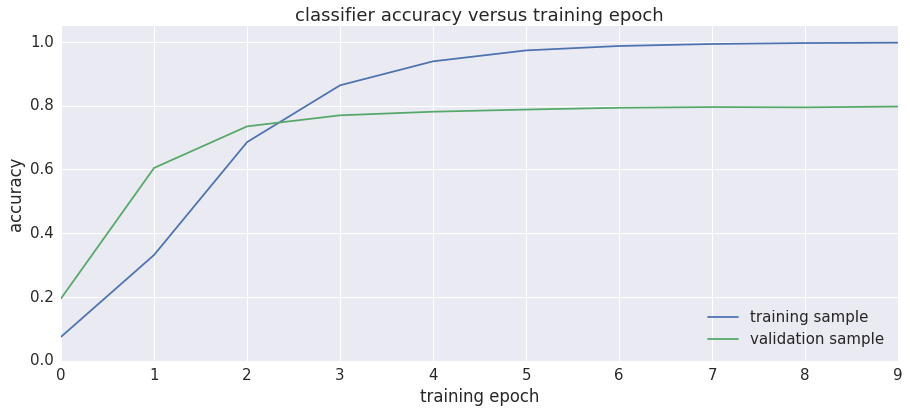

In [18]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['acc']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_acc']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier accuracy versus training epoch')
ax.set_ylabel('accuracy')
ax.set_xlabel('training epoch')
ax.set_ylim(0.0, 1.05)
ax.legend(loc='lower right')
plt.savefig('figs/accuracy.png')

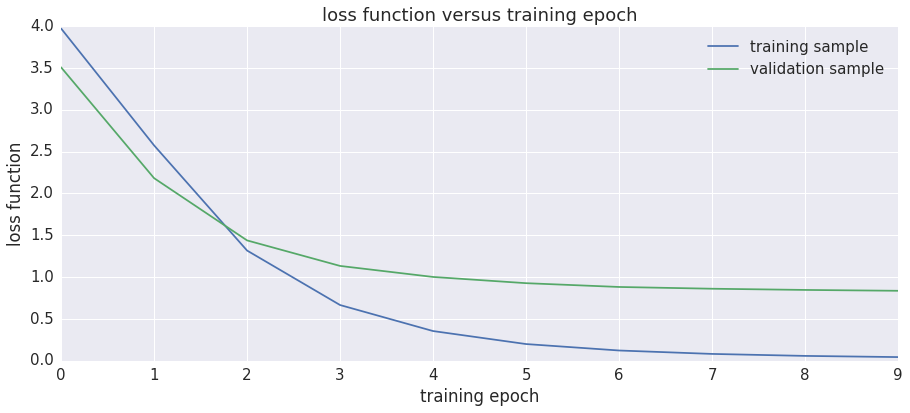

In [19]:
#plot loss function vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('loss function versus training epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()
plt.savefig('figs/loss.png')

In [26]:
#predict authors of the text-chunks in the testing sample
x_test, y_test = tokenize(test, tokenizer)
y_test_predict_2D = lstm_model.predict(x_test)
test = test.reset_index(drop=True)
test['author_id_pred'] = pd.Series([np.argmax(y) for y in y_test_predict_2D])
cols = [u'author', u'title', u'author_id', u'author_id_pred', 'input_file', u'text_chunk']
test[cols][-10:]

,author,title,author_id,author_id_pred,input_file,text_chunk
20034,Adam Smith,Wealth Of Nations,1,41,iso/etext02/wltnt10.txt,"them, than those who have been accused of the ..."
20035,Xenophon,Cyropaedia,87,67,iso/etext00/cyrus10.txt,effect: the missiles fell fast on shields and ...
20036,Maupassant,Original Short Stories,60,60,iso/etext02/gm00v11.txt,She gazed at them each evening with a weight a...
20037,Adams,The Education Of Henry Adams,2,2,iso/etext00/eduha10.txt,"Adams to Sotheby's, where a small collection o..."
20038,Dana,Two Years Before The Mast,17,60,iso/etext00/2yb4m10.txt,"well calculated for dancing, and he moved abou..."
20039,Thomas Malory,Le Mort D'Arthur,81,81,iso/etext98/2mart10.txt,"defended me so highly, that meseemeth she will..."
20040,Anne C. Lynch Botta,Handbook Of Universal Literature,3,3,iso/etext05/8unlt10.txt,"impulse to the German mind, the effects of whi..."
20041,Sir James George Frazer,The Golden Bough,72,72,iso/etext03/bough11.txt,"who now animates him or her, and if, as often ..."
20042,Dickens,Bleak House,22,80,iso/etext97/blkhs10.txt,"""If you get into debt, you must pay your debts..."
20043,Teresa Of Avila,The Life Of St. Teresa Of Jesus,76,76,iso/etext05/8trsa10.txt,extreme loneliness; how much greater my comfor...


In [27]:
#calculate model accuracy vs author
accuracy_list = []
for input_file in test['input_file'].unique():
    idx = test['input_file'] == input_file
    df = test[idx]
    idx = df['author_id'] == df['author_id_pred']
    accuracy = idx.sum()*1.0/idx.count()
    author = df['author'].values[0]
    title = df['title'].values[0]
    N_chunks = (train['input_file'] == input_file).sum()
    d = {'author':author, 'title':title, 'input_file':input_file, 'N_chunks':N_chunks, 'accuracy':accuracy}
    accuracy_list += [d]
accuracy = pd.DataFrame(accuracy_list).sort_values('accuracy', ascending=False).reset_index(drop=True)
accuracy.head(10)

,N_chunks,accuracy,author,input_file,title
0,1320,1.000000,"Cervantes, In Spanish",iso/etext99/2donq10.txt,Don Quijote
1,665,1.000000,Emile Zola,iso/etext04/8lssm10u.txt,L'Assommoir
2,500,0.993711,Victor Hugo,iso/etext04/handi10.txt,Han D'Islande
3,535,0.946309,Unknown Icelanders,iso/etext96/njals10.txt,Njal'S Saga
4,856,0.943478,Thomas Malory,iso/etext98/2mart10.txt,Le Mort D'Arthur
5,793,0.925926,Jules Verne,iso/etext98/milnd11.txt,The Mysterious Island
6,873,0.921569,Mohammed,iso/etext02/koran12a.txt,The Koran
7,955,0.919847,David Hume,iso/etext03/trthn10.txt,A Treatise Of Human Nature
8,894,0.912863,Teresa Of Avila,iso/etext05/8trsa10.txt,The Life Of St. Teresa Of Jesus
9,939,0.909483,John Payne,iso/etext04/tftaa10.txt,Tales From The Arabic Volumes 1-3


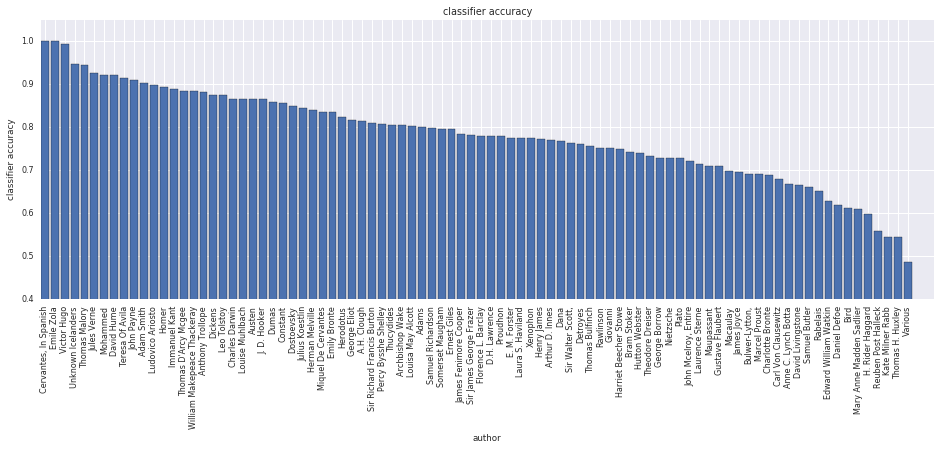

In [54]:
#plot model accuracy vs author
sns.set(font_scale=0.8, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(16, 5))
xp = accuracy.index
yp = accuracy['accuracy']
authors = accuracy['author']
ax.bar(xp, yp)
ax.set_xticks(xp+0.4)
ax.set_xticklabels(authors)
ax.set_title('classifier accuracy vs author')
ax.set_ylabel('classifier accuracy')
ax.set_xlabel('author')
plt.xticks(rotation=90)
ax.set_ylim(0.4, 1.05)
plt.savefig('figs/accuracy_vs_author.png')

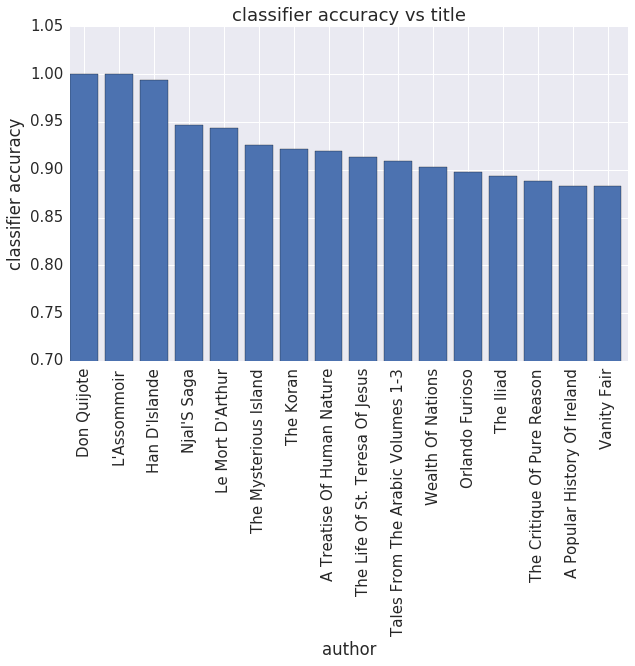

In [68]:
#plot model accuracy vs title, for high-accuracy books
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(10, 6))
idx = accuracy.index < 16
xp = accuracy.index[idx]
yp = accuracy['accuracy'][idx]
authors = accuracy['title'][idx]
ax.bar(xp, yp)
ax.set_xticks(xp+0.4)
ax.set_xticklabels(authors)
ax.set_title('classifier accuracy vs title')
ax.set_ylabel('classifier accuracy')
ax.set_xlabel('author')
plt.xticks(rotation=90)
ax.set_ylim(0.7, 1.05)
plt.savefig('figs/accuracy_vs_title-high.png')

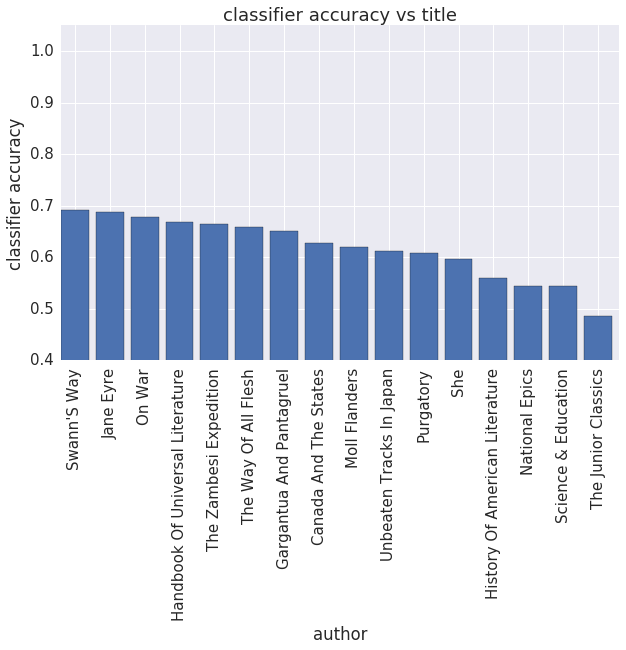

In [69]:
#plot model accuracy vs title, for low-accuracy books
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(10, 6))
idx = accuracy.index > accuracy.index.max() - 16
xp = accuracy.index[idx]
yp = accuracy['accuracy'][idx]
authors = accuracy['title'][idx]
ax.bar(xp, yp)
ax.set_xticks(xp+0.4)
ax.set_xticklabels(authors)
ax.set_title('classifier accuracy vs title')
ax.set_ylabel('classifier accuracy')
ax.set_xlabel('author')
plt.xticks(rotation=90)
ax.set_ylim(0.4, 1.05)
plt.savefig('figs/accuracy_vs_title-low.png')

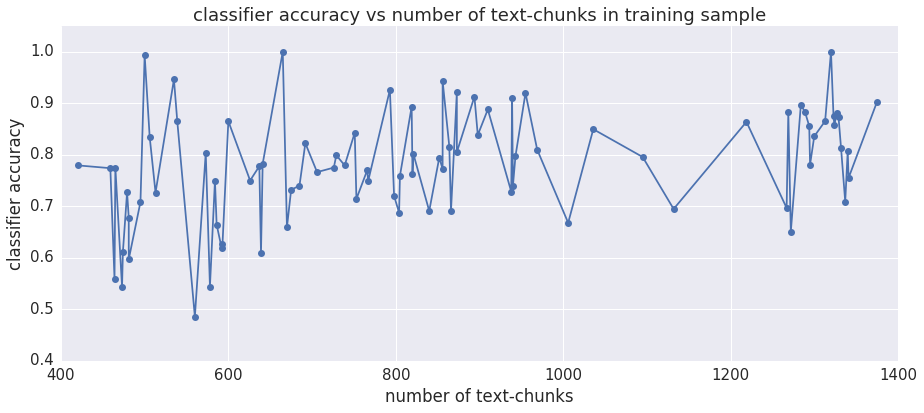

In [78]:
#plot accuracy versus training N_chunks
fig, ax = plt.subplots(1,1, figsize=(15, 6))
df = accuracy.sort_values('N_chunks')
xp = df['N_chunks']
yp = df['accuracy']
ax.plot(xp, yp, marker='o')
ax.set_title('classifier accuracy vs number of text-chunks in training sample')
ax.set_ylabel('classifier accuracy')
ax.set_xlabel('number of text-chunks')
ax.set_ylim(0.4, 1.05)
plt.savefig('figs/accuracy_vs_Nchunks.png')

In [25]:
#done!
print 'training loss fn  = ', fit_history.history['loss'][-1]
print 'validation accuracy = ', fit_history.history['val_acc'][-1]
time_stop = time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

training loss fn  =  0.044421576325
validation accuracy =  0.797438849739
execution time (minutes) =  40.5216290991
